# AI Tools for Actuaries
## Chapter 5: CANN approach in Python
### Author: Michael Mayer and Mario Wuthrich
### Version April 2025

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
from statsmodels.formula.api import glm
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(500)
# See all pandas columns
pd.set_option("display.max_columns", None)

# Helps to keep results reproducible
tf.config.experimental.enable_op_determinism()


### Load data

In [2]:
# Load the data
df = pd.read_parquet("../../Data/freMTPL2freq.parquet")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   IDpol       678007 non-null  float64 
 1   Exposure    678007 non-null  float64 
 2   Area        678007 non-null  category
 3   VehPower    678007 non-null  int32   
 4   VehAge      678007 non-null  int32   
 5   DrivAge     678007 non-null  int32   
 6   BonusMalus  678007 non-null  int32   
 7   VehBrand    678007 non-null  category
 8   VehGas      678007 non-null  category
 9   Density     678007 non-null  int32   
 10  Region      678007 non-null  category
 11  ClaimTotal  678007 non-null  float64 
 12  ClaimNb     678007 non-null  float64 
 13  LearnTest   678007 non-null  object  
dtypes: category(4), float64(4), int32(5), object(1)
memory usage: 41.4+ MB
None


,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,LearnTest
0,4156370.0,0.06,D,6,6,20,100,B2,Regular,525,R82,0.0,0.0,L
1,4006798.0,0.29,E,6,7,29,59,B12,Diesel,2498,R72,0.0,0.0,L
2,6084964.0,0.46,C,7,10,27,68,B1,Diesel,123,R82,0.0,0.0,L
3,2228865.0,0.08,D,4,15,34,50,B2,Regular,1109,R24,0.0,0.0,L
4,4141911.0,1.00,A,5,22,44,50,B3,Diesel,34,R72,0.0,0.0,L


### Pre-process data for GLM

In [3]:
# Create GLM features
driv_age_lev = ["18-20", "21-25", "26-30", "31-40", "41-50", "51-70", "71+"]
driv_age_lev2 = ["31-40", *[lev for lev in driv_age_lev if lev != "31-40"]]

df = df.assign(
    AreaGLM=lambda x: x.Area.cat.codes + 1,  # Make Area code continuous
    VehPowerGLM=lambda x: pd.Categorical(x.VehPower.clip(0, 9)),  # Make categorical
    # Create age categories
    VehAgeGLM=lambda x: pd.cut(
        x.VehAge, bins=[-1, 5, 12, 101], labels=["0-5", "6-12", "12+"]
    ),
    DrivAgeGLM=lambda x: pd.Categorical(
        pd.cut(x.DrivAge, bins=[17, 20, 25, 30, 40, 50, 70, 101], labels=driv_age_lev),
        categories=driv_age_lev2,
    ),
    BonusMalusGLM=lambda x: x.BonusMalus.clip(0, 150),  # Censor bonus-malus level
    DensityGLM=lambda x: np.log(x.Density),  # Log-transform density
)

df.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,LearnTest,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM
0,4156370.0,0.06,D,6,6,20,100,B2,Regular,525,R82,0.0,0.0,L,4,6,6-12,18-20,100,6.263398
1,4006798.0,0.29,E,6,7,29,59,B12,Diesel,2498,R72,0.0,0.0,L,5,6,6-12,26-30,59,7.823246
2,6084964.0,0.46,C,7,10,27,68,B1,Diesel,123,R82,0.0,0.0,L,3,7,6-12,26-30,68,4.812184
3,2228865.0,0.08,D,4,15,34,50,B2,Regular,1109,R24,0.0,0.0,L,4,4,12+,31-40,50,7.011214
4,4141911.0,1.00,A,5,22,44,50,B3,Diesel,34,R72,0.0,0.0,L,1,5,12+,41-50,50,3.526361


### Split into learning sample and test sample

In [4]:
# Split data (this uses the same split and order as in Wuthrich-Merz, Springer 2023)
learn, test = (df[df.LearnTest == subset].copy() for subset in ("L", "T"))

print(f"Learning set size: {learn.shape[0]}")
print(f"Test set size: {test.shape[0]}")

Learning set size: 610206
Test set size: 67801


## GLM analysis

In [5]:
# Fit GLM
model = glm("ClaimNb ~ DrivAgeGLM + VehBrand + VehGas + DensityGLM + AreaGLM",
            data=learn,
            offset=np.log(learn['Exposure']),
            family=sm.families.Poisson())

glm_results = model.fit()

# Display model summary
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               610206
Model:                            GLM   Df Residuals:                   610186
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -98513.
Date:                Tue, 29 Apr 2025   Deviance:                   1.5138e+05
Time:                        14:34:39   Pearson chi2:                 1.02e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.004052
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.2590    

### Calculate deviance losses

In [6]:
from sklearn.metrics import mean_poisson_deviance

# Get predictions
learn['GLM'] = glm_results.predict(learn)*learn['Exposure']   
test['GLM'] = glm_results.predict(test)*test['Exposure']

# Calculate in-sample and out-of-sample deviance
learn_deviance, test_deviance = (
    100*mean_poisson_deviance(x.ClaimNb/x.Exposure, x.GLM/x.Exposure, sample_weight=x.Exposure) for x in (learn, test)
)

print("Deviance Losses:")
print(f"Learning sample: {learn_deviance:.3f}")
print(f"Test sample: {test_deviance:.3f}")

Deviance Losses:
Learning sample: 46.954
Test sample: 47.179


## CANN step: using the GLM predictors as offsets in the FNN

### Pre-process data for FNN - using entity embedding
### Define the Scikit-Learn preprocessor

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OrdinalEncoder,
    StandardScaler,
)


def clip_and_scale(upper):
    pipe = Pipeline(
        steps=[
            ("clip", FunctionTransformer(lambda x: np.clip(x, a_min=0, a_max=upper))),
            ("scale", StandardScaler()),
        ]
    )
    return pipe


density = Pipeline(
    steps=[
        ("log", FunctionTransformer(lambda x: np.log(x).round(2))),
        ("scale", StandardScaler()),
    ]
)

area = Pipeline(
    steps=[
        ("encode", OrdinalEncoder()),
        ("scale", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        (
            "scale",
            clip_and_scale([20, 90, 150, 15]),
            ["VehAge", "DrivAge", "BonusMalus", "VehPower"],
        ),
        ("area", area, ["Area"]),
        ("density", density, ["Density"]),
        ("veh_gas", FunctionTransformer(lambda x: x == "Diesel"), ["VehGas"]),
        ("veh_brand", OrdinalEncoder(), ["VehBrand", "Region"]),
    ],
    verbose_feature_names_out=False,
)

# Just a check: Fit preprocessor to training data and apply to some lines from test
preprocessor.set_output(transform="pandas").fit(learn)
preprocessor.transform(test.head())

,VehAge,DrivAge,BonusMalus,VehPower,Area,Density,VehGas,VehBrand,Region
610206,-1.29173,-1.309026,1.937902,-1.196789,0.513423,0.298236,False,3.0,14.0
610207,-1.29173,-0.884378,2.578711,-0.709264,0.513423,0.795155,False,3.0,0.0
610208,-1.29173,-0.884378,2.578711,-0.709264,0.513423,0.795155,False,3.0,0.0
610209,-1.29173,1.663510,-0.497176,-0.709264,0.513423,0.666918,False,3.0,0.0
610210,-1.29173,0.460341,-0.625338,-0.709264,-0.209473,-0.476529,False,3.0,20.0


### Split in covariates X, responses y, GLM prior for CANN step


In [8]:
X_learn = preprocessor.fit_transform(learn)
X_test = preprocessor.transform(test)

y_learn, v_learn = learn.ClaimNb, learn.GLM
y_test, v_test = test.ClaimNb, test.GLM

### Define FNN of depth 3 with entity embeddings for categorical variables

In [9]:
# define FNN with entity embedding and three hidden layers
def create_fnn(seed, n_features, hidden_layers, kk, bb, freeze_hidden=False):
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(seed)

    design_input = keras.layers.Input(shape=(n_features,))
    volume_input = keras.layers.Input(shape=(1,))
    
    # Extract brand and region features (last two columns)
    brand_input = keras.layers.Lambda(lambda x: x[:, -2:-1])(design_input)
    region_input = keras.layers.Lambda(lambda x: x[:, -1:])(design_input)
    
    # Embedding layers
    brand_embed = keras.layers.Embedding(input_dim=kk[0], output_dim=bb[0], input_length=1, trainable=not freeze_hidden)(brand_input)
    brand_embed = keras.layers.Flatten()(brand_embed)
    
    region_embed = keras.layers.Embedding(input_dim=kk[1], output_dim=bb[1], input_length=1, trainable=not freeze_hidden)(region_input)
    region_embed = keras.layers.Flatten()(region_embed)
    
    # Continuous features (all except last two columns)
    continuous_features = keras.layers.Lambda(lambda x: x[:, :-2])(design_input)
    
    # Concatenate all features
    x = keras.layers.Concatenate()([continuous_features, brand_embed, region_embed])
    
    # build the network
    for q in hidden_layers:
        x = keras.layers.Dense(q, activation="tanh", trainable=not freeze_hidden)(x)
    x = keras.layers.Dense(1, activation="exponential")(x)

    output = keras.layers.Multiply()([x, volume_input])

    model = keras.Model(inputs=[design_input, volume_input], outputs=output)

    return model


### Prepare the inputs

In [11]:
SEED = 1234
HIDDEN = [20, 15, 10]
M_FEAT = X_learn.shape[1]
KK = [len(learn['VehBrand'].unique()), len(learn['Region'].unique())]
BB  = [2,2]


# Create model with three hidden layers
model = create_fnn(SEED, M_FEAT, HIDDEN, KK, BB)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 2)      │         22 │ lambda[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 2)      │         44 │ lambda_1[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 7)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 11)        │          0 │ lambda_2[0][0],   │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20)        │        240 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 15)        │        315 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        160 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         11 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1)         │          0 │ dense_3[0][0],    │
│                     │                   │            │ input_layer_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 792 (3.09 KB)

 Trainable params: 792 (3.09 KB)

 Non-trainable params: 0 (0.00 B)

### Replicate GLM results within the FNN architecture

In [14]:

from sklearn.metrics import mean_poisson_deviance

# Initialize to the GLM results
w0 = model.get_weights()
#w0[-2] = np.zeros_like(w0[-2])
#w0[-1] = np.zeros_like(w0[-1])
w0[-2] *= 0
w0[-1] *= 0
model.set_weights(w0)


def score(model, X, y, v, w):
    """Evaluate the model using sklearn's mean_poisson_deviance."""
    pred = model.predict([X, v], batch_size=int(1e6), verbose=0).flatten()
    return 100*mean_poisson_deviance(y/w, pred/w, sample_weight=w)


print(f"Poisson Deviance (Learn): {score(model, X_learn, y_learn, v_learn, learn.Exposure):.3f}")
print(f"Poisson Deviance (Test): {score(model, X_test, y_test, v_test, test.Exposure):.3f}")

Poisson Deviance (Learn): 46.954
Poisson Deviance (Test): 47.179


### Train the CANN model

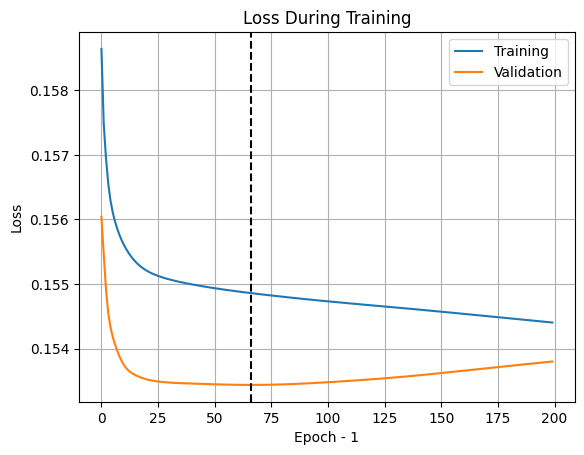

In [15]:
# checkpoint for early stopping
checkpoint_path = f"./Networks/CANN_{SEED}.weights.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor="val_loss", save_best_only=True, save_weights_only=True
)

# Compile model
model.compile(loss="poisson", optimizer="nadam")

# Train model
history = model.fit(
    [X_learn, v_learn],
    y_learn,
    validation_split=0.1,
    batch_size=5000,
    epochs=200,
    verbose=0,
    callbacks=[checkpoint],
)

# Plot training history (vertical line at best validation loss)
fig = (
    pd.DataFrame(history.history)
    .rename(columns={"loss": "Training", "val_loss": "Validation"})
    .plot(xlabel="Epoch - 1", ylabel="Loss", title="Loss During Training", grid=True)
)
_ = fig.axvline(
    np.argmin(model.history.history["val_loss"]), color="black", linestyle="--"
)


### CANN results

In [16]:
# Load best weights and evaluate
model.load_weights(checkpoint_path)
w2 = model.get_weights()

print("Poisson Deviance GLM (Learn-Test):", round(learn_deviance,3), round(test_deviance, 3))

print(f"Poisson Deviance CANN (Learn-Test): {score(model, X_learn, y_learn, v_learn, learn.Exposure):.3f}, {score(model, X_test, y_test, v_test, test.Exposure):.3f}")

Poisson Deviance GLM (Learn-Test): 46.954 47.179
Poisson Deviance CANN (Learn-Test): 44.968, 44.932


### Plot the marginalized expected frequency for the Driver Age input variable

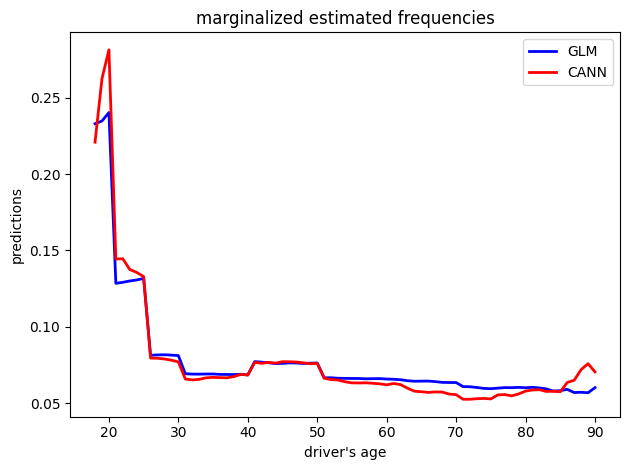

In [17]:

learn['CANN'] = model.predict([X_learn, v_learn], batch_size=10**6, verbose=0)
test['CANN'] = model.predict([X_test, v_test], batch_size=10**6, verbose=0)

# Create figure
# Calculate aggregated frequencies
learn["DrivAgeX"]=learn["DrivAge"].clip(upper=90)
aggr = learn.groupby('DrivAgeX').agg({
    'GLM': 'sum',
    'CANN': 'sum',
    'Exposure': 'sum'
}).reset_index()


aggr['GLM'] = aggr['GLM'] / aggr['Exposure']
aggr['CANN'] = aggr['CANN'] / aggr['Exposure']

# Plot marginalized estimated frequencies
plt.plot(aggr['DrivAgeX'], aggr['GLM'], 'blue', linewidth=2, label='GLM')
plt.plot(aggr['DrivAgeX'], aggr['CANN'], 'red', linewidth=2, label='CANN')
plt.xlabel("driver's age")
plt.ylabel('predictions')
plt.title('marginalized estimated frequencies')
plt.legend()

plt.tight_layout()
plt.show()